# Generative Medical Image Segmentation

In [27]:
# --- Import Libraries ---
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch import nn
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))

from scripts.data import get_loaders
from scripts.funcs import run_model

# Define device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# --- Set Plot Style ---
sns.set_style("dark")
plt.style.use("dark_background")


# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 64
NUM_WORKERS = 0


### Define Dataloaders

In [28]:
train_loader, test_loader = get_loaders("../data/", batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_workers=NUM_WORKERS)

### Define Model

In [29]:
# --- Define Encoder ---
class Encoder(nn.Module):
    def __init__(self, z_dim, input_dim = IMG_SIZE*IMG_SIZE*3):
        self.input_dim = input_dim
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.Softplus(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.Softplus(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(32, 2 * z_dim))

    def forward(self, x):
        # Compute the hidden units
        hidden = self.conv(x)
        # then return a mean vector and a (positive) square root covariance
        mu, log_var = hidden.chunk(2, dim=-1)
        return mu, torch.exp(log_var)
       
    
# --- Define Decoder ---
class Decoder(nn.Module):
    def __init__(self, xz_dim, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.fc = nn.Linear(xz_dim, 64)
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=IMG_SIZE, stride=IMG_SIZE),
            nn.Softplus(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.conv(self.fc(z).view(-1, 64, 1, 1))

### Define VAE

In [30]:
# --- Define VAE ---
class CVAE(nn.Module):
    def __init__(self, z_dim=64, hidden_dim=248, input_dim=IMG_SIZE*IMG_SIZE*3):
        self.input_dim = input_dim
        self.output_dim = IMG_SIZE*IMG_SIZE
        super().__init__()

        # Define the encoder and decoder networks
        self.encoder = Encoder(z_dim, self.input_dim)
        self.decoder = Decoder(z_dim+self.input_dim, self.output_dim)
        self.z_dim = z_dim

    # Define the model p(y|z)p(z)
    def model(self, x, y=None):
        pyro.module("decoder", self.decoder)
        batch_size = x.size(0)
        with pyro.plate("data", batch_size):

            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=device)

            # sample from prior
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))


            # flatten the image x
            x_flatten = x.reshape(-1, self.input_dim)

            # condact the image x to the latent variable z
            xz = torch.cat([z, x_flatten], dim=1)

            # decode the latent code z
            yhat = self.decoder.forward(xz).view(batch_size, -1)

            if y is not None:
                pyro.sample("obs", 
                        dist.Bernoulli(yhat, validate_args=False).to_event(1), 
                        obs=y.reshape(-1, self.output_dim),)
                
            else:
                pyro.deterministic('obs', yhat.detach())

            return yhat

    # Define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x, y=None):
        # use the encoder to get the parameters used to define q(z|x)
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):

            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)

            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

In [32]:
# --- Training the CVAE ---
num_epochs = 500
test_frequency = 10
lr = 1e-3

vae = CVAE(z_dim=64, hidden_dim=248, input_dim=IMG_SIZE*IMG_SIZE*3)

# setup the optimizer
optimizer = Adam({"lr": lr})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

vae = run_model(vae, svi, train_loader, test_loader, num_epochs=num_epochs, test_frequency=test_frequency, lr=lr, device=device)

[Epoch 1]
Mean train loss: 521.3854
Mean test loss: 197.1577

[Epoch 2]
Mean train loss: 196.2061

[Epoch 3]
Mean train loss: 169.0207

[Epoch 4]
Mean train loss: 148.5603

[Epoch 5]
Mean train loss: 132.5090

[Epoch 6]
Mean train loss: 119.5343

[Epoch 7]
Mean train loss: 109.8889

[Epoch 8]
Mean train loss: 101.4369

[Epoch 9]
Mean train loss: 95.1872

[Epoch 10]
Mean train loss: 92.1118

[Epoch 11]
Mean train loss: 83.8170
Mean test loss: 81.4819

[Epoch 12]
Mean train loss: 79.4041

[Epoch 13]
Mean train loss: 75.5211

[Epoch 14]
Mean train loss: 67.8882

[Epoch 15]
Mean train loss: 63.2870

[Epoch 16]
Mean train loss: 60.4204

[Epoch 17]
Mean train loss: 57.0397

[Epoch 18]
Mean train loss: 55.8644

[Epoch 19]
Mean train loss: 53.1879

[Epoch 20]
Mean train loss: 52.4144

[Epoch 21]
Mean train loss: 50.7362
Mean test loss: 60.3135

[Epoch 22]
Mean train loss: 48.4790

[Epoch 23]
Mean train loss: 50.2160

[Epoch 24]
Mean train loss: 46.6715

[Epoch 25]
Mean train loss: 45.0415

[Ep

KeyboardInterrupt: 

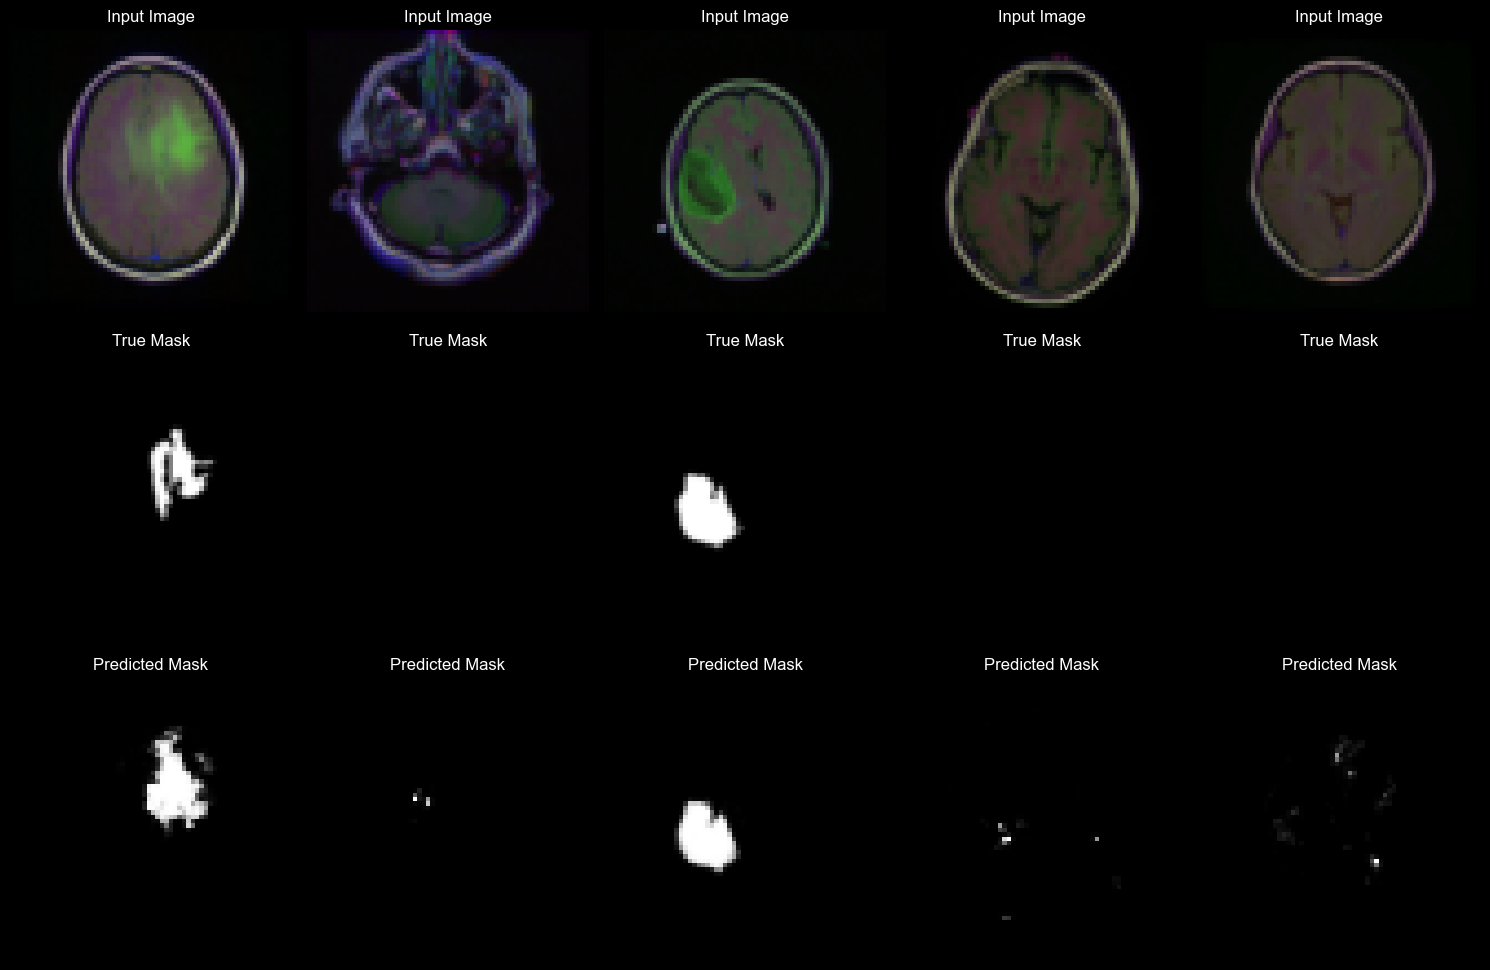

In [33]:
def visualize_predictions(model, loader, num_images=5):
    model.eval()
    images, true_masks = next(iter(loader))
    images = images.to(device)
    true_masks = true_masks.to(device)
    with torch.no_grad():
        # Get model predictions and reshape to the mask dimensions
        pred = model.model(images, None)
    # Reshape predictions to match the true mask shape
    pred = pred.reshape(true_masks.size()).cpu().numpy()
    true_masks = true_masks.cpu().numpy()
    images = images.cpu().numpy()
    
    fig, axes = plt.subplots(3, num_images, figsize=(15, 10))
    for i in range(num_images):
         # Show input image
         axes[0, i].imshow(images[i].transpose(1, 2, 0))
         axes[0, i].set_title("Input Image")
         axes[0, i].axis("off")
         # Show true mask (using grayscale for clarity)
         axes[1, i].imshow(true_masks[i].transpose(1, 2, 0), cmap='gray')
         axes[1, i].set_title("True Mask")
         axes[1, i].axis("off")
         # Show predicted mask (using grayscale for clarity)
         axes[2, i].imshow(pred[i].transpose(1, 2, 0), cmap='gray')
         axes[2, i].set_title("Predicted Mask")
         axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()


visualize_predictions(vae, test_loader)